# Preprocessing the flu data

The preprocessing aggregates a number of different data files into a single
`.json` file. Here, a user or determines a set of states.
For each state, the`.json` records information about demographics, vaccination,
and flu-related tweets.

In [1]:
%matplotlib inline

In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from __future__ import division
from datetime import datetime

In [3]:
def check_all_counties_exist():
    '''Check Flu_Vacc_Tweet_TRAIN.json has all counties from StateInfo.json'''
    with open('fludata/StateInfo.json') as f:
        stateinfo = json.load(f)
    with open('fludata/Flu_Vacc_Tweet_TRAIN.json', 'r') as f:
        twitter = json.load(f)
    for state in stateinfo:
        counties = stateinfo[state]['Counties'].keys()
        assert all(c in twitter for c in counties)

In [4]:
def find_counties_with_missing_vaccination():
    '''Report all counties which do not have a series for vacciation rates.'''
    with open('fludata/Flu_Vacc_Tweet_TRAIN.json', 'r') as f:
        twitter = json.load(f)
    missing = [c for c in twitter if not twitter[c].get('Vaccination percentage %', [])]
    return [twitter[m]['Name'] for m in missing]

In [5]:
def datesort(dates):
    '''Keys of `dates` are of the form 08/24/2015, values are real numbers.'''
    reorded = sorted(dates, key=lambda d: datetime.strptime(d, '%m/%d/%Y'))
    return [(d, dates[d]) for d in reorded]

In [6]:
def get_first(pairs):
    '''Retrieve list of first element from a list of pairs.'''
    return [p[0] for p in pairs]
def get_second(pairs):
    '''Retrieve list of second element from a list of pairs.'''
    return [p[1] for p in pairs]

In [7]:
def compute_first_difference(series):
    '''Computes first difference from a sorted series of dates, values.'''
    sorted_dates = get_first(series)
    sorted_values = get_second(series)
    sorted_values1d = np.diff(sorted_values)
    if len(sorted_values) > 0:
        assert len(sorted_values1d) == len(sorted_dates) - 1
    return zip(sorted_dates[1:], sorted_values1d)

In [8]:
def get_county_data(county, twitter=None):
    if twitter is None:
        with open('fludata/Flu_Vacc_Tweet_TRAIN.json', 'r') as f:
            twitter = json.load(f)
    # Sort the tweets by date.
    tweets = twitter[county].get('No. of Tweets', [])
    sorted_tweets = datesort(tweets)
    twitter[county]['Sorted No. of Tweets'] = sorted_tweets
    # Sort the vaccs by date.
    vaccs = twitter[county].get('Vaccination percentage %', [])
    sorted_vaccs = datesort(vaccs)
    twitter[county]['Sorted Vaccination percentage %'] = datesort(vaccs)
    # Add first difference of "Vacciation percetnage % diff" to each county.
    twitter[county]['Sorted Vaccination percentage % diff'] = compute_first_difference(sorted_vaccs)
    return twitter[county]

In [9]:
def get_state_data(state, stateinfo=None, twitter=None, ili=None):
    # Load data from disk.
    if stateinfo is None:
        with open('fludata/StateInfo.json') as f:
            stateinfo = json.load(f)
    if twitter is None:
        with open('fludata/Flu_Vacc_Tweet_TRAIN.json') as f:
            twitter = json.load(f)
    if ili is None:
        with open('fludata/Flu_ILI_TRAIN.csv') as f:
            ili = pd.read_csv(f)
    # Require state to exist in ili.
    if state not in ili.columns:
        raise ValueError('No ILI data for state: %s' % (state,))
    # Dictionary of state data.
    state_data = dict()
    # Retrieve data for all counties in the state.
    counties_raw = {
        county: get_county_data(county, twitter)
        for county in stateinfo[state]['Counties']
    }
    # Consider those counties which have Vaccination data.
    # Only 3 counties out of 3000+ have missing data, so we can ignore them rather
    # rather than devise a custom aggregation strategy for missing data.
    counties = {
        county: data
        for county, data in counties_raw.iteritems()
        if data['Sorted Vaccination percentage %']
    }
    # Assert all weeks of (vaccination, tweets) are the same across counties.
    weeks = get_first(counties[counties.keys()[0]]['Sorted Vaccination percentage %'])
    for series in ['Sorted Vaccination percentage %', 'Sorted No. of Tweets']:
        assert all(get_first(counties[c][series]) == weeks for c in counties)
    # Compute weight of county by its population.
    total_population = float(sum(counties[c]['Population, 2010'] for c in counties))
    county_weights = {
        c: counties[c]['Population, 2010'] / total_population
        for c in counties
    }
    #####################################################
    # -- COMPUTE aggregate state_data['No. of Tweets'] --
    #####################################################
    tweets_aggregate = [
        (week, sum(counties[c]['Sorted No. of Tweets'][i][1] for c in counties))
        for (i, week) in enumerate(weeks)
    ]
    state_data['No. of Tweets'] = tweets_aggregate
    #####################################################
    # -- COMPUTE aggregate state_data['No. of Tweets'] --
    #####################################################
    # For each county, compute the number of vaccinated citizens.
    def compute_vacc_population(county):
        vacc_dates = get_first(counties[county]['Sorted Vaccination percentage %'])
        vacc_percentages = get_second(counties[county]['Sorted Vaccination percentage %'])
        vacc_populations = [v/100. * counties[county]['Population, 2010'] for v in vacc_percentages]
        return zip(vacc_dates, vacc_populations)
    for county in counties:
        counties[county]['Sorted Vaccination population'] = compute_vacc_population(county)
    # Construct the state aggregate of Vaccination population.
    vacc_population_aggregate = [
        (week, sum(counties[c]['Sorted Vaccination population'][i][1] for c in counties))
        for (i, week) in enumerate(weeks)
    ]
    vacc_percentage_aggregate = [
        (week, vacc_pop / total_population)
        for (week, vacc_pop) in vacc_population_aggregate
    ]
    vacc_percentage_aggreate1d = compute_first_difference(vacc_percentage_aggregate)
    state_data['Vaccination percentage % diff'] = vacc_percentage_aggreate1d
    #####################################################
    # -- COMPUTE aggregate state_data['ILI Rate'] --
    #####################################################
    weeks_tweets = [datetime.strptime(w,'%m/%d/%Y') for w in weeks]
    weeks_ili = [datetime.strptime(w, '%m/%d/%Y') for w in ili['Ending']]
    assert len(weeks) == len(weeks_ili)
    assert all(w_tweet == w_ili for (w_tweet, w_ili) in zip(weeks_tweets, weeks_ili))
    state_data['ILI Rate'] = zip(
        weeks,
        (float(str.replace(rate, '%','')) if isinstance(rate, str) else rate for rate in ili[state]),
    )
    ##########################################################################
    # -- COMPUTE aggregate state_data['Median household income, 2009-2013'] --
    ##########################################################################
    state_data['Median household income, 2009-2013 (Avg)'] = sum([
        counties[c]['Median household income, 2009-2013'] * county_weights[c]
        for c in counties
    ])
    ###########################################################################################################
    # -- COMPUTE aggregate state_data['Per capita money income in past 12 months (2013 dollars), 2009-2013'] --
    ###########################################################################################################
    spending_total = sum([
        counties[c]['Population, 2010']
         * counties[c]['Per capita money income in past 12 months (2013 dollars), 2009-2013']
        for c in counties
    ])
    state_data['Per capita money income in past 12 months (2013 dollars), 2009-2013'] = \
        spending_total / total_population
    # Returns a dict of all the aggregates.
    return state_data

In [10]:
def save_aggregates(states, data):
    '''Save a JSON file of state aggregates.'''
    with open('fludata/generated/Flu_Vacc_ILI_State_Aggregate.json', 'w') as f:
        json.dump(dict(zip(states, data)), f)

In [11]:
def chainplot(tweet, vacc, ili, ax=None):
    '''Create plot of the three timeseries.'''
    assert len(tweet) == len(vacc) == len(ili)
    if ax is None:
        fig, ax = plt.subplots()
    t = range(len(tweet))
    ax.plot(t, tweet, label='tweets')
    # Rescales vacc to match tweet
    ax.plot(t, np.max(tweet)*rescale(vacc), label='vaccs')
    # Rescales ili to match tweet
    ax.plot(t, np.max(tweet)*rescale(ili), label='ili')
    # Fix up
    ax.set_yticklabels([])
    ax.grid()
    ax.legend(framealpha=0)
    ax.set_xlabel('Week')
    return ax

def rescale(series):
    '''Rescale data in series between 0 and 1.'''
    low = np.min(series)
    high = np.max(series)
    return (series-low) / float(high-low)
    
def nullify(values):
    '''Convert nans to 0 so matplotlib can plot them.'''
    return [v if not np.isnan(v) else 0 for v in values]

def generate_plots(states, data):
    '''Generate timeseries plots for each state.'''
    for s, d in zip(states, data):
        ax = chainplot(
            nullify(get_second(d['No. of Tweets'][1:])),
            nullify(get_second(d['Vaccination percentage % diff'])),
            nullify(get_second(d['ILI Rate'][1:])),
        )
        ax.set_title('State %s' % (s))

In [12]:
# States with ILI data and their aggregate data.
STATES = ['MA', 'MS', 'NC', 'RI', 'TN', 'TX',]
DATA = [get_state_data(s) for s in STATES]

In [13]:
# Dump the JSON file.
save_aggregates(STATES, DATA)

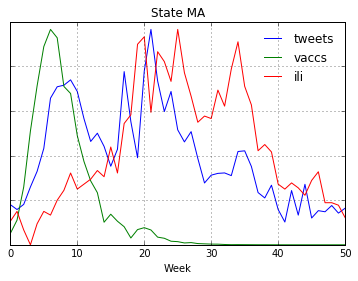

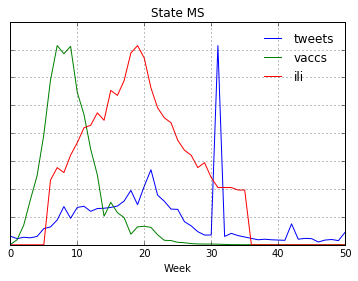

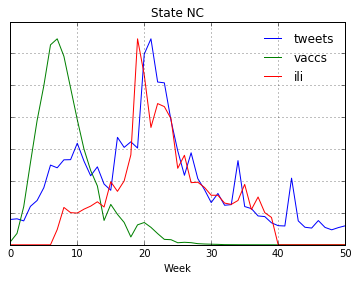

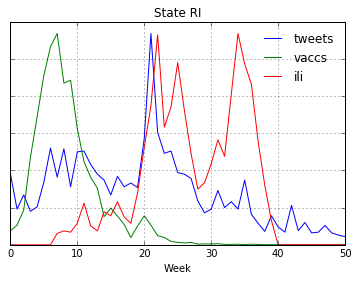

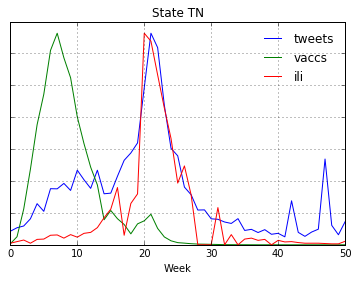

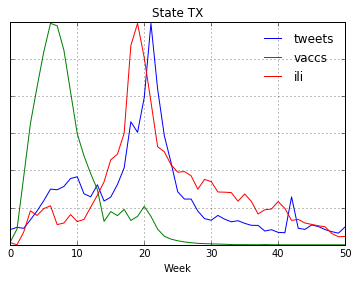

In [14]:
generate_plots(STATES, DATA)